# Index   

0. [Importing libraries](##Importing-libraries) 


1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)

 [Reading the data set](###Reading-the-data-set)

2. [Data Enginnering](#Dara-Engineering)
 
3. [Model Screening with Pycaret](#Model-screening-with-PycaretModel-Screening)

4. [Tunning Random Forest Hyperparameters with Optuna](##Random-Forest-Hyperparameters-tunning-with-Optuna)

5. [Prediction of test_X](##test_X-prediction)



### Importing libraries

In [2]:
#Data exploration & manipulation
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import seaborn as sns
import matplotlib.style as style 
import datetime as dt
import os
import matplotlib.pyplot as plt

#ML Models search and optimisation
from pycaret.classification import * 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import optuna
from sklearn.model_selection import cross_val_score

%matplotlib inline

# Exploratory Data Analysis


In [78]:
# Import space_X_train.csv
space_X_train = pd.read_csv(r'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Hackathon_Talent_Squad\initial_docs\space_X_train.csv', index_col=0)

In [79]:
space_X_train.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


In [80]:
space_X_train.isnull().sum()

sensor_1    0
sensor_2    0
sensor_3    0
sensor_4    0
sensor_5    0
sensor_6    0
target      0
dtype: int64

In [81]:
space_X_train.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.204656,0.199249,-0.378140,-0.206425,-0.186419,-0.433229,1.980476
std,1.543613,1.614024,1.450548,1.442225,1.501573,1.188791,1.410537
min,-6.683655,-5.383371,-6.147055,-5.653594,-5.912521,-4.433189,0.000000
25%,-1.171340,-0.877386,-1.365990,-1.259403,-1.211685,-1.131944,1.000000
50%,-0.443868,0.320507,-0.439745,-0.176504,-0.195751,-0.406754,2.000000
75%,0.890023,1.321430,0.662898,0.866879,0.851843,0.348593,3.000000
max,4.565547,6.700133,4.157518,4.371912,5.068783,4.016324,4.000000


Values of sensors are very similar (range from -0.433 to 6.700). There is no null values to be cleaned.

In [82]:
y = space_X_train.target

Text(0, 0.5, '# of instances')

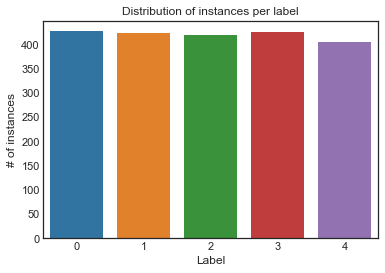

In [83]:

#Label distribution checking
sns.set_context("notebook")
style.use('seaborn-white')    
counter = Counter(y)
dist_plot=sns.barplot(x=list(counter.keys()), y=list(counter.values()))
dist_plot.set_title('Distribution of instances per label')
dist_plot.set_xlabel('Label')
dist_plot.set_ylabel('# of instances')

In [84]:
ratio_labels= [x/len(y) for x in list(counter.values())]
ratio_labels

[0.19285714285714287,
 0.20333333333333334,
 0.20142857142857143,
 0.20285714285714285,
 0.19952380952380952]

Distribution of samples are very similiar each other, there is no minoritay/majotary class in the label column.

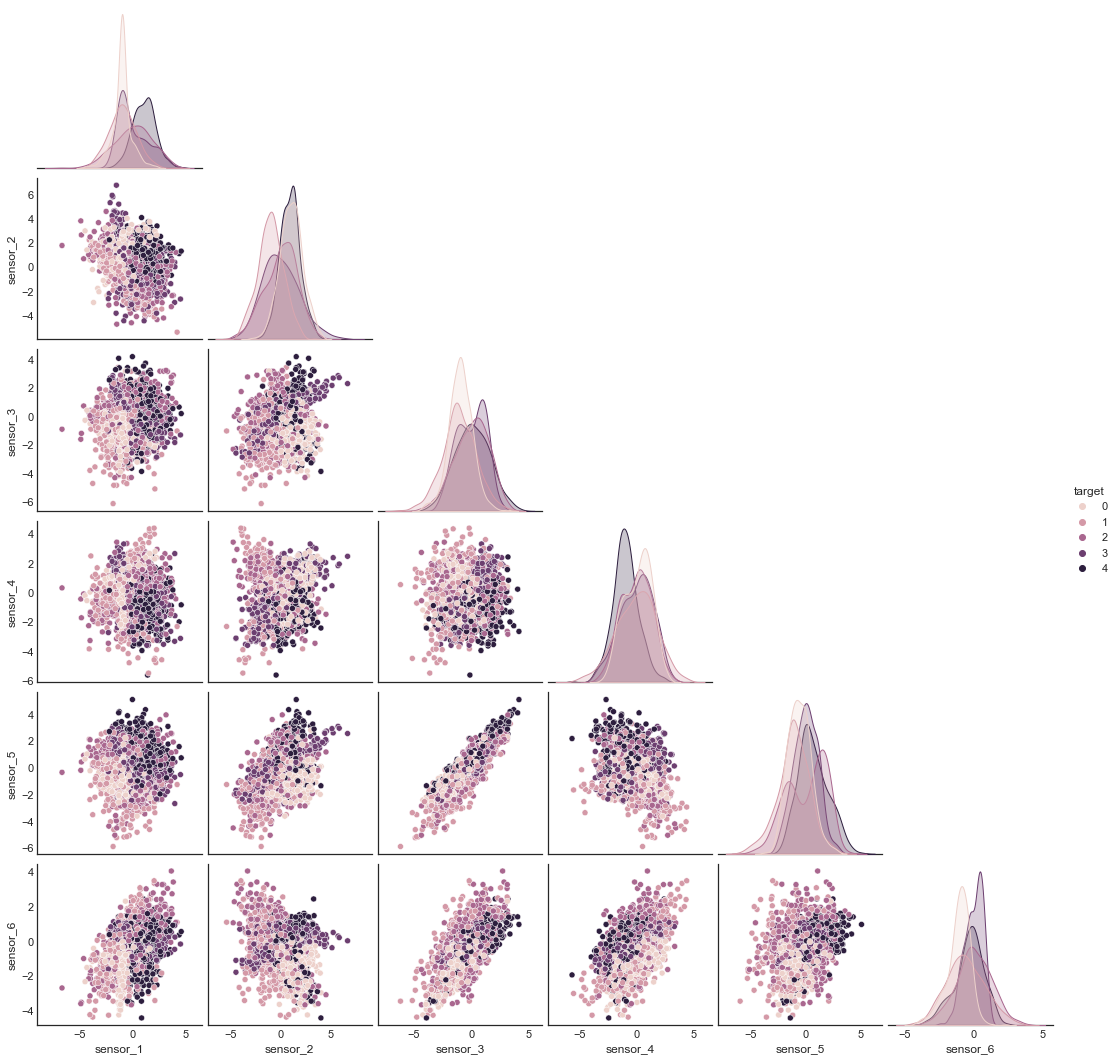

In [85]:
sns.pairplot(space_X_train, corner=True,hue='target')

From the previous graph it can be concluded that:
* Each class has a gaussian type distribution.
* The different labels form clusters for certain sensors, such differences are the ground of predictions.

<AxesSubplot:>

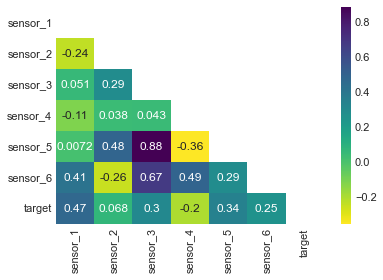

In [86]:
# Getting the Lower Triangle of the co-relation matrix
matrix = np.triu(space_X_train.corr())
sns.heatmap(space_X_train.corr(), annot=True, cmap='viridis_r', mask=matrix)

Sensors 3 and 5 are highly correlated but it does not involve a correlation with the differents labels/status.

# Dara Engineering

There is no need to clean, and it may be tried some data engineering of the Data set. Let's consider to check normalization, standarization and treating outliers with robustscaler:

In [14]:
space_X_train.columns

Index(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'target'],
      dtype='object')

In [15]:

x = space_X_train.drop('target',axis=1).values #returns a numpy array
numerical_cols=['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6']

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
space_X_train_min_max_scaled = pd.DataFrame(x_scaled)

scaler = preprocessing.RobustScaler()
space_X_train_robust = scaler.fit_transform(x)
space_X_train_robust = pd.DataFrame(space_X_train_robust, columns =numerical_cols)

scaler = preprocessing.StandardScaler()
space_X_train_standard = scaler.fit_transform(x)
space_X_train_standard = pd.DataFrame(space_X_train_standard, columns =numerical_cols)


In [16]:
space_X_train_min_max_scaled ['target'] = space_X_train['target']
space_X_train_robust ['target'] = space_X_train['target']
space_X_train_standard ['target'] = space_X_train['target']


In [17]:
#space_X_train_scaled['target'] = space_X_train['target']

# Model screening with Pycaret

With Pycaret we test the dataframe with several models to check its performance with :

In [127]:
setup(space_X_train,
          target='target'
    )
best_model_rfc=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7808,0.9503,0.7814,0.7839,0.7795,0.7259,0.7272,0.8230
et,Extra Trees Classifier,0.7753,0.9495,0.7761,0.7783,0.7741,0.7191,0.7203,0.4600
lightgbm,Light Gradient Boosting Machine,0.7679,0.9469,0.7683,0.7739,0.7671,0.7097,0.7115,0.3920
knn,K Neighbors Classifier,0.7549,0.9347,0.7544,0.7588,0.7531,0.6933,0.6951,0.1280
gbc,Gradient Boosting Classifier,0.7488,0.9400,0.7495,0.7555,0.7469,0.6858,0.6883,2.1020
dt,Decision Tree Classifier,0.6977,0.8110,0.6988,0.7020,0.6969,0.6221,0.6235,0.0370
ada,Ada Boost Classifier,0.5725,0.8025,0.5744,0.5631,0.5599,0.4655,0.4688,0.2750
nb,Naive Bayes,0.5528,0.8323,0.5539,0.5572,0.5360,0.4405,0.4471,0.0330
qda,Quadratic Discriminant Analysis,0.5337,0.8479,0.5301,0.5766,0.5219,0.4162,0.4285,0.0360
lr,Logistic Regression,0.5289,0.7829,0.5285,0.4879,0.4901,0.4102,0.4194,0.0520


In [128]:
print(best_model_rfc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=8955, verbose=0,
                       warm_start=False)


Let's try with the data modified with data engineering: MinMaxScaler, Standarization and RobustScaler. 

In [121]:
setup(space_X_train_min_max_scaled,
          target='target', 
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7618,0.9474,0.7626,0.7674,0.7614,0.7021,0.7035,1.0430
et,Extra Trees Classifier,0.7495,0.9455,0.7499,0.7538,0.7484,0.6868,0.6882,0.5200
lightgbm,Light Gradient Boosting Machine,0.7461,0.9437,0.7464,0.7498,0.7450,0.6825,0.6838,0.5360
gbc,Gradient Boosting Classifier,0.7406,0.9418,0.7408,0.7450,0.7392,0.6756,0.6772,1.6430
knn,K Neighbors Classifier,0.7325,0.9253,0.7322,0.7400,0.7312,0.6654,0.6674,0.1500
dt,Decision Tree Classifier,0.6774,0.7983,0.6778,0.6807,0.6757,0.5966,0.5981,0.0320
qda,Quadratic Discriminant Analysis,0.6331,0.8970,0.6284,0.6610,0.6261,0.5402,0.5490,0.0480
nb,Naive Bayes,0.5521,0.8378,0.5510,0.5546,0.5371,0.4393,0.4451,0.0290
ada,Ada Boost Classifier,0.5514,0.8119,0.5531,0.5393,0.5353,0.4393,0.4435,0.2780
lda,Linear Discriminant Analysis,0.5140,0.7884,0.5126,0.4890,0.4886,0.3917,0.3970,0.0240


In [122]:
print(best_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1431, verbose=0,
                       warm_start=False)


In [123]:
setup(space_X_train_standard,
          target='target'
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7686,0.9493,0.7687,0.7731,0.7667,0.7107,0.7125,0.7000
rf,Random Forest Classifier,0.7679,0.9463,0.7681,0.7717,0.7662,0.7098,0.7113,1.0650
et,Extra Trees Classifier,0.7584,0.9476,0.7585,0.7621,0.7573,0.6979,0.6991,0.6500
gbc,Gradient Boosting Classifier,0.7543,0.9417,0.7544,0.7572,0.7525,0.6928,0.6942,1.8040
knn,K Neighbors Classifier,0.7400,0.9281,0.7401,0.7440,0.7378,0.6749,0.6767,0.1260
dt,Decision Tree Classifier,0.6808,0.8004,0.6809,0.6847,0.6791,0.6009,0.6024,0.0460
qda,Quadratic Discriminant Analysis,0.5915,0.8619,0.5896,0.6025,0.5804,0.4888,0.4956,0.0370
ada,Ada Boost Classifier,0.5827,0.8211,0.5829,0.5737,0.5653,0.4782,0.4833,0.3260
nb,Naive Bayes,0.5596,0.8380,0.5589,0.5522,0.5395,0.4490,0.4553,0.0480
lr,Logistic Regression,0.5269,0.7979,0.5266,0.4835,0.4869,0.4083,0.4165,0.0660


In [124]:
print(best_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3958, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [125]:
setup(space_X_train_robust,
          target='target'
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7591,0.9451,0.7598,0.7645,0.7585,0.6988,0.7002,0.4830
rf,Random Forest Classifier,0.7577,0.9439,0.7582,0.7625,0.7571,0.6970,0.6984,0.9210
lightgbm,Light Gradient Boosting Machine,0.7516,0.9425,0.7523,0.7566,0.7510,0.6894,0.6907,0.7150
gbc,Gradient Boosting Classifier,0.7441,0.9389,0.7450,0.7510,0.7431,0.6800,0.6821,2.3830
knn,K Neighbors Classifier,0.7386,0.9314,0.7395,0.7431,0.7368,0.6732,0.6751,0.1470
dt,Decision Tree Classifier,0.6596,0.7871,0.6609,0.6620,0.6584,0.5745,0.5756,0.0410
qda,Quadratic Discriminant Analysis,0.5882,0.8541,0.5871,0.6057,0.5842,0.4848,0.4893,0.0310
nb,Naive Bayes,0.5806,0.8411,0.5813,0.5898,0.5662,0.4758,0.4826,0.0280
ada,Ada Boost Classifier,0.5507,0.7993,0.5532,0.5389,0.5333,0.4387,0.4436,0.3060
lr,Logistic Regression,0.5398,0.7888,0.5415,0.5326,0.5123,0.4249,0.4327,0.0550


In [126]:
print(best_model)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=6408, verbose=0,
                     warm_start=False)


## Random Forest Hyperparameters tunning with Pycaret

In [129]:
def scoring_f1(y_test,X_test,method): #generation of f1 macro
    '''
    Funtion to get the f1_macro metric 
    Input: 
        y_test = real target label of the data set used
        X_test = features used to determine the label target
        method = model evaluated which will predict the target labels
    Output:
        Float number corresponding to the F1_macro.'''

    f1score=f1_score(y_test,
                     method.predict(X_test),
                     average= 'macro'
)        
    return f1score  

To avoid data leakage in Pycaret, the model to be tuned will be created with the train set:

In [104]:
X['target']=y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,stratify=y)
X_train.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,target
19,-1.153663,-0.490551,-1.221787,1.198523,-1.645471,-0.397307,1
807,0.051587,-2.850896,-1.648007,1.069979,-2.540411,0.311744,2
974,-1.615734,-0.396239,-0.605161,0.191728,-0.660267,-0.590922,1
1746,1.700228,0.049878,-0.189630,-1.797814,0.570287,-0.449787,4
905,-1.906572,-0.770195,-2.545250,0.390334,-2.492019,-1.664043,1


In [107]:
setup(X_train,
          target='target'
    )
    
best_model2=compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7468,0.9353,0.7464,0.7491,0.7441,0.6834,0.6851,0.9220
et,Extra Trees Classifier,0.7369,0.9377,0.7368,0.7397,0.7347,0.6710,0.6725,0.5290
lightgbm,Light Gradient Boosting Machine,0.7368,0.9280,0.7362,0.7407,0.7351,0.6709,0.6726,0.6590
knn,K Neighbors Classifier,0.7269,0.9204,0.7264,0.7314,0.7238,0.6584,0.6608,0.2350
gbc,Gradient Boosting Classifier,0.7250,0.9269,0.7245,0.7290,0.7224,0.6562,0.6582,1.2920
dt,Decision Tree Classifier,0.6489,0.7807,0.6481,0.6588,0.6476,0.5611,0.5637,0.0350
nb,Naive Bayes,0.5590,0.8310,0.5601,0.5641,0.5433,0.4488,0.4556,0.0320
ada,Ada Boost Classifier,0.5381,0.7986,0.5369,0.5321,0.5203,0.4222,0.4281,0.3700
lr,Logistic Regression,0.5354,0.7863,0.5344,0.5117,0.5100,0.4187,0.4246,0.0500
qda,Quadratic Discriminant Analysis,0.5318,0.8438,0.5327,0.5632,0.5292,0.4152,0.4223,0.0360


In [110]:
model_rf_pycaret = best_model2
X_test.drop('target', axis=1, inplace=True) #target column should be removed
print (f' score f1-macro of Random Forest Classifier with Pycaret = {scoring_f1(y_test,X_test,model_rf_pycaret)}')

 score f1-macro of Random Forest Classifier with Pycaret = 0.7838359368988101


In [111]:
# train model
rf_model = create_model('rf')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7117,0.9197,0.7093,0.7168,0.7094,0.6390,0.6411
1,0.7748,0.9404,0.7771,0.7825,0.7699,0.7185,0.7226
2,0.7636,0.9494,0.7629,0.7688,0.7622,0.7045,0.7062
3,0.7364,0.9168,0.7370,0.7414,0.7339,0.6706,0.6731
4,0.7818,0.9413,0.7817,0.7851,0.7806,0.7270,0.7286
5,0.7545,0.9362,0.7552,0.7555,0.7540,0.6931,0.6936
6,0.7545,0.9470,0.7531,0.7581,0.7479,0.6930,0.6964
7,0.7364,0.9429,0.7350,0.7379,0.7358,0.6703,0.6708
8,0.7636,0.9381,0.7601,0.7575,0.7590,0.7044,0.7051
9,0.6909,0.9210,0.6929,0.6878,0.6886,0.6137,0.6140


In [113]:
print (f' score f1 of rf created by Pycaret not tunned = {scoring_f1(y_test,X_test,rf_model)}') 

 score f1 of rf created by Pycaret not tunned = 0.7838359368988101


In [114]:
# tune model
tuned_rf_model = tune_model(rf_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6847,0.9174,0.6841,0.6915,0.6841,0.6053,0.6072
1,0.7658,0.9326,0.7703,0.7755,0.7601,0.7076,0.7121
2,0.7545,0.9497,0.7559,0.7585,0.7506,0.6932,0.6959
3,0.7273,0.9239,0.7279,0.7307,0.7245,0.6593,0.6615
4,0.7818,0.9401,0.7813,0.7949,0.7815,0.7269,0.7310
5,0.7455,0.9486,0.7465,0.7449,0.7446,0.6818,0.6821
6,0.7091,0.9438,0.7076,0.7151,0.6991,0.6363,0.6412
7,0.7545,0.9417,0.7544,0.7581,0.7539,0.6932,0.6942
8,0.7455,0.9396,0.7423,0.7455,0.7407,0.6816,0.6839
9,0.6818,0.9245,0.6847,0.6786,0.6771,0.6025,0.6040


In [115]:
print (f' Score f1 of Random Forest by Pycaret and Tuned = {scoring_f1(y_test,X_test,tuned_rf_model)}') 

 Score f1 of Random Forest by Pycaret and Tuned = 0.7815456377077837


The initial model worked better than the tunned one regarding the f1_macro metric. 

## Random Forest Hyperparameters tunning with Optuna

In [27]:
import optuna

In [28]:
X=space_X_train.copy()
y=X.target
X.drop('target',axis=1, inplace=True)

In [29]:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=853, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=853, verbose=0,
                       warm_start=False)

In [30]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,stratify=y)
    
    bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
    max_depth = trial.suggest_int('max_depth', 1, 100000)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 100000)
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 20)
    
    rf_cl = RandomForestClassifier(bootstrap = bootstrap, 
                                   max_depth = max_depth, 
                                   max_features = max_features,
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


In [31]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-06-23 11:52:05,190] A new study created in memory with name: no-name-f53d9d29-9461-4fb0-b834-ad6e2c2972dd
[I 2022-06-23 11:52:30,456] Trial 0 finished with value: 0.7004913597053948 and parameters: {'bootstrap': 'True', 'max_depth': 66082, 'max_features': 'sqrt', 'max_leaf_nodes': 76240, 'n_estimators': 580, 'n_jobs': 10}. Best is trial 0 with value: 0.7004913597053948.
[I 2022-06-23 11:52:48,376] Trial 1 finished with value: 0.7006636708743464 and parameters: {'bootstrap': 'True', 'max_depth': 96513, 'max_features': 'sqrt', 'max_leaf_nodes': 66454, 'n_estimators': 537, 'n_jobs': 6}. Best is trial 1 with value: 0.7006636708743464.
[I 2022-06-23 11:53:24,007] Trial 2 finished with value: 0.698631527181818 and parameters: {'bootstrap': 'True', 'max_depth': 34056, 'max_features': 'sqrt', 'max_leaf_nodes': 81885, 'n_estimators': 789, 'n_jobs': 14}. Best is trial 1 with value: 0.7006636708743464.
[I 2022-06-23 11:53:38,818] Trial 3 finished with value: 0.6983238435736154 and paramet

In [32]:
import plotly.io as pio #To fix an issue with the renderer of graphs in VSC
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [33]:
pio.renderers.default = "notebook_connected"

In [34]:
optuna.visualization.plot_param_importances(study).show()

In [35]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [36]:
study.best_params

{'bootstrap': 'True',
 'max_depth': 53895,
 'max_features': 'auto',
 'max_leaf_nodes': 2684,
 'n_estimators': 415,
 'n_jobs': 2}

In [37]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1, 10000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 20)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-23 11:59:33,732] Trial 20 finished with value: 0.7079068384236837 and parameters: {'max_depth': 1663, 'max_leaf_nodes': 4807, 'n_estimators': 667, 'n_jobs': 4}. Best is trial 20 with value: 0.7079068384236837.
[I 2022-06-23 11:59:46,957] Trial 21 finished with value: 0.7079068384236837 and parameters: {'max_depth': 1603, 'max_leaf_nodes': 4770, 'n_estimators': 671, 'n_jobs': 4}. Best is trial 20 with value: 0.7079068384236837.
[I 2022-06-23 12:00:01,325] Trial 22 finished with value: 0.7080345207236094 and parameters: {'max_depth': 1188, 'max_leaf_nodes': 4816, 'n_estimators': 702, 'n_jobs': 4}. Best is trial 22 with value: 0.7080345207236094.
[I 2022-06-23 12:00:14,854] Trial 23 finished with value: 0.7079068384236837 and parameters: {'max_depth': 1524, 'max_leaf_nodes': 5049, 'n_estimators': 671, 'n_jobs': 4}. Best is trial 22 with value: 0.7080345207236094.
[I 2022-06-23 12:00:32,316] Trial 24 finished with value: 0.7075025925290774 and parameters: {'max_depth': 1435, 'ma

In [38]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [72]:
optuna.visualization.plot_param_importances(study).show()

In [55]:
study.best_params

{'max_depth': 5517, 'max_leaf_nodes': 9597, 'n_estimators': 697, 'n_jobs': 20}

In [73]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1, 10000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 4000, 20000)
    n_estimators =  trial.suggest_int('n_estimators', 100, 2000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 6)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-22 21:11:23,132] Trial 40 finished with value: 0.7074064556519206 and parameters: {'max_depth': 4029, 'max_leaf_nodes': 9680, 'n_estimators': 1186, 'n_jobs': 3}. Best is trial 25 with value: 0.7143263560792905.
[I 2022-06-22 21:11:56,421] Trial 41 finished with value: 0.7181364961274778 and parameters: {'max_depth': 3954, 'max_leaf_nodes': 9634, 'n_estimators': 1652, 'n_jobs': 3}. Best is trial 41 with value: 0.7181364961274778.
[I 2022-06-22 21:12:30,275] Trial 42 finished with value: 0.7158193735337595 and parameters: {'max_depth': 3776, 'max_leaf_nodes': 9521, 'n_estimators': 1601, 'n_jobs': 3}. Best is trial 41 with value: 0.7181364961274778.
[I 2022-06-22 21:13:11,510] Trial 43 finished with value: 0.7165170441222501 and parameters: {'max_depth': 3866, 'max_leaf_nodes': 9737, 'n_estimators': 1731, 'n_jobs': 3}. Best is trial 41 with value: 0.7181364961274778.
[I 2022-06-22 21:13:47,311] Trial 44 finished with value: 0.7165170441222501 and parameters: {'max_depth': 3887,

In [74]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [75]:
optuna.visualization.plot_param_importances(study).show()

In [76]:
study.best_params

{'max_depth': 3954, 'max_leaf_nodes': 9634, 'n_estimators': 1652, 'n_jobs': 3}

In [88]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1000, 5000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 4000, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 200, 800)
    n_jobs =  trial.suggest_int('n_jobs', 2, 6)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-22 21:43:37,439] Trial 87 finished with value: 0.7175489913138143 and parameters: {'max_depth': 3796, 'max_leaf_nodes': 9507, 'n_estimators': 300, 'n_jobs': 2}. Best is trial 79 with value: 0.7196057856124378.
[I 2022-06-22 21:43:46,164] Trial 88 finished with value: 0.7147255742713291 and parameters: {'max_depth': 3820, 'max_leaf_nodes': 9512, 'n_estimators': 284, 'n_jobs': 2}. Best is trial 79 with value: 0.7196057856124378.
[I 2022-06-22 21:43:53,907] Trial 89 finished with value: 0.7178178511107678 and parameters: {'max_depth': 3861, 'max_leaf_nodes': 9519, 'n_estimators': 271, 'n_jobs': 2}. Best is trial 79 with value: 0.7196057856124378.
[I 2022-06-22 21:44:02,785] Trial 90 finished with value: 0.7157421601978676 and parameters: {'max_depth': 3774, 'max_leaf_nodes': 9500, 'n_estimators': 270, 'n_jobs': 2}. Best is trial 79 with value: 0.7196057856124378.
[I 2022-06-22 21:44:09,648] Trial 91 finished with value: 0.7133318266746401 and parameters: {'max_depth': 3710, 'ma

In [96]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [90]:
optuna.visualization.plot_param_importances(study).show()

In [91]:
study.optimize(objective, n_trials=10)

[I 2022-06-22 21:48:46,336] Trial 107 finished with value: 0.7175300946995377 and parameters: {'max_depth': 4033, 'max_leaf_nodes': 9300, 'n_estimators': 277, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:48:54,585] Trial 108 finished with value: 0.7186777660609284 and parameters: {'max_depth': 3964, 'max_leaf_nodes': 9396, 'n_estimators': 282, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:49:01,878] Trial 109 finished with value: 0.7186777660609284 and parameters: {'max_depth': 4017, 'max_leaf_nodes': 9359, 'n_estimators': 282, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:49:10,188] Trial 110 finished with value: 0.7147255742713291 and parameters: {'max_depth': 3983, 'max_leaf_nodes': 9388, 'n_estimators': 284, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:49:17,794] Trial 111 finished with value: 0.7209692523524147 and parameters: {'max_depth': 4010

In [92]:
study.optimize(objective, n_trials=10)


[I 2022-06-22 21:50:46,089] Trial 117 finished with value: 0.7209692523524147 and parameters: {'max_depth': 4032, 'max_leaf_nodes': 9445, 'n_estimators': 281, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:50:53,034] Trial 118 finished with value: 0.7175300946995377 and parameters: {'max_depth': 4014, 'max_leaf_nodes': 9424, 'n_estimators': 276, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:51:01,442] Trial 119 finished with value: 0.7192498090050643 and parameters: {'max_depth': 4020, 'max_leaf_nodes': 9318, 'n_estimators': 280, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:51:08,604] Trial 120 finished with value: 0.7152246576635225 and parameters: {'max_depth': 4040, 'max_leaf_nodes': 9262, 'n_estimators': 292, 'n_jobs': 3}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:51:16,973] Trial 121 finished with value: 0.717389587355369 and parameters: {'max_depth': 4017,

In [95]:
study.optimize(objective, n_trials=10)

[I 2022-06-22 21:54:30,871] Trial 138 finished with value: 0.7196780727604631 and parameters: {'max_depth': 4084, 'max_leaf_nodes': 9242, 'n_estimators': 266, 'n_jobs': 4}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:54:37,726] Trial 139 finished with value: 0.717602381847563 and parameters: {'max_depth': 4119, 'max_leaf_nodes': 9240, 'n_estimators': 268, 'n_jobs': 4}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:54:46,338] Trial 140 finished with value: 0.7176169363377707 and parameters: {'max_depth': 4061, 'max_leaf_nodes': 9318, 'n_estimators': 264, 'n_jobs': 4}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:54:53,524] Trial 141 finished with value: 0.7196780727604631 and parameters: {'max_depth': 4045, 'max_leaf_nodes': 9321, 'n_estimators': 269, 'n_jobs': 4}. Best is trial 97 with value: 0.7209692523524147.
[I 2022-06-22 21:55:01,519] Trial 142 finished with value: 0.7157421601978676 and parameters: {'max_depth': 4101,

In [87]:
study.best_params

{'max_depth': 3770, 'max_leaf_nodes': 9507, 'n_estimators': 274, 'n_jobs': 2}

In [110]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [120]:
study.best_params

{'max_depth': 2511, 'max_leaf_nodes': 9249, 'n_estimators': 610, 'n_jobs': 2}

The best f1_macro reached tunning with Optuna is 0,721.

## test_X prediction

The initial Pycaret screening done with the whole training data set(which also gave Random Forset as best model) is the best model to be used with the x_test data set as it has been trained with all the data available to predict the X_test.

Charge test_X dataset to be predicted. We check its statistically ressemblance to the training data set.:

In [130]:
test_x=pd.read_csv(r'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Hackathon_Talent_Squad\initial_docs\space_X_test.csv',index_col=0)

test_x.isnull().sum()

sensor_1    0
sensor_2    0
sensor_3    0
sensor_4    0
sensor_5    0
sensor_6    0
dtype: int64

In [131]:
test_x.shape

(900, 6)

In [133]:
test_x.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,-0.170339,0.135481,-0.447035,-0.201708,-0.263349,-0.445490
std,1.485402,1.547202,1.394437,1.487102,1.450823,1.215000
min,-5.084203,-4.292548,-4.628992,-6.732089,-5.196997,-4.823971
25%,-1.098759,-0.934171,-1.460497,-1.163163,-1.182667,-1.152891
50%,-0.386297,0.341427,-0.464239,-0.177710,-0.233699,-0.410182
75%,0.881170,1.246296,0.626893,0.870332,0.679282,0.399597
max,4.636012,4.612113,3.299946,5.996929,3.917118,5.357953


test_X is very similar to the training set.

In [134]:
x_test_pred = best_model_rfc.predict(test_x)
x_test_pred

array([1, 3, 2, 0, 3, 2, 4, 0, 2, 3, 1, 4, 3, 1, 4, 4, 4, 3, 2, 0, 1, 2,
       4, 0, 0, 3, 0, 2, 2, 4, 2, 2, 4, 3, 3, 1, 0, 4, 3, 0, 4, 2, 3, 2,
       2, 0, 0, 1, 0, 4, 4, 0, 1, 0, 4, 4, 1, 3, 3, 0, 3, 0, 3, 0, 4, 0,
       1, 0, 2, 3, 0, 1, 4, 0, 4, 0, 0, 1, 2, 3, 4, 3, 0, 3, 1, 1, 2, 3,
       1, 2, 2, 4, 1, 1, 0, 1, 4, 2, 1, 4, 0, 0, 0, 4, 2, 4, 4, 4, 1, 2,
       4, 1, 3, 3, 3, 0, 3, 4, 2, 2, 0, 4, 4, 3, 1, 2, 4, 1, 3, 2, 2, 1,
       4, 0, 0, 2, 3, 0, 0, 4, 0, 4, 3, 2, 1, 3, 4, 3, 4, 4, 1, 2, 1, 2,
       0, 4, 2, 4, 4, 2, 0, 2, 3, 3, 1, 4, 1, 3, 2, 0, 1, 2, 4, 4, 1, 2,
       3, 0, 3, 4, 2, 1, 0, 4, 2, 2, 3, 3, 4, 1, 1, 1, 2, 4, 0, 0, 4, 4,
       1, 2, 0, 2, 4, 3, 2, 2, 3, 1, 1, 3, 0, 0, 2, 1, 1, 3, 4, 2, 2, 1,
       2, 3, 2, 0, 3, 0, 0, 2, 2, 3, 0, 2, 4, 3, 4, 4, 0, 3, 3, 3, 1, 4,
       3, 0, 2, 0, 2, 2, 2, 0, 4, 3, 1, 3, 1, 1, 0, 3, 2, 4, 2, 1, 0, 2,
       2, 4, 2, 4, 1, 2, 1, 4, 2, 0, 3, 0, 1, 4, 2, 4, 1, 1, 3, 1, 2, 4,
       0, 0, 2, 2, 3, 1, 0, 2, 0, 0, 4, 4, 1, 3, 0,

In [135]:
predictions_df=pd.DataFrame(x_test_pred,columns=['final_status'])
predictions_df

,final_status
0,1
1,3
2,2
3,0
4,3
...,...
895,3
896,4
897,0
898,3


In [137]:
predictions_df.to_csv(r'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Hackathon_Talent_Squad\predictions.csv',index=False)

In [138]:
pip list > requirements.txt #generates file with all packages installed in the environment used

Note: you may need to restart the kernel to use updated packages.
